In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LinearRegression, Lasso

import torch

from transformers import BertTokenizerFast, BertModel


# import other files
from extract_features import load_features, load_features_by_name

# constant
SAVE = True
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [2]:
# process data
data = pd.read_csv("./Data/processed_peptides10.csv")  # load data

# get peptide sequences
peptides = data.iloc[:, 0].values.tolist()  # ['Peptide1', 'Peptide2'...]

# load features
features_x = load_features().iloc[:, 1:].values

# extract mmp labels
all_mmp_y = data.iloc[:, 1:].values

# import Bert-Base-Protein model
checkpoint = 'unikei/bert-base-proteins'
tokenizer = BertTokenizerFast.from_pretrained(checkpoint)

In [3]:
# train ridge model and get params for each mmp
params = []
for mmp_i in range(18):
    lr = Ridge(1)
    lr.fit(features_x, all_mmp_y[:, mmp_i])
    params.append(lr.coef_)  # get the params
params = np.stack(params, axis=0)

In [4]:
# sum the params for each feature set
binary_weight = np.abs(params[:, :160]).sum(axis=1)
cksaap_weight = np.abs(params[:, 160:2560]).sum(axis=1)
aac_weight = np.abs(params[:, 2560:2580]).sum(axis=1)
knn_weight = np.abs(params[:, 2580:]).sum(axis=1)
weight_sum_array = np.stack([binary_weight, cksaap_weight, aac_weight, knn_weight], axis=0)

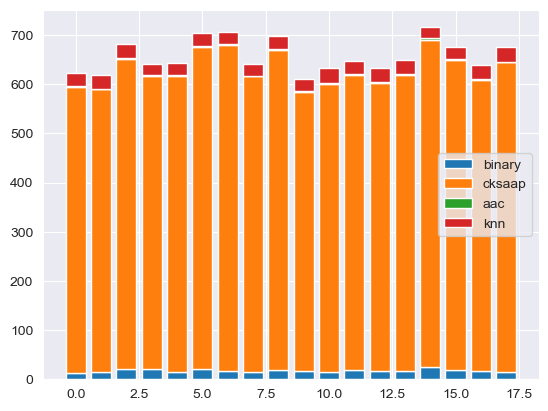

In [5]:
# draw the bar figure. However, as some feature sets, such as cksaap, have too many features (2400 in 2600), this graph does not objectively reflect the importance of different features.
plt.bar(range(18), weight_sum_array[0], label="binary")
plt.bar(range(18), weight_sum_array[1], bottom=weight_sum_array[0], label="cksaap")
plt.bar(range(18), weight_sum_array[2], bottom=weight_sum_array[0:2].sum(axis=0), label="aac")
plt.bar(range(18), weight_sum_array[3], bottom=weight_sum_array[0:3].sum(axis=0), label="knn")
plt.legend()
plt.show()

In [6]:
# average the params for each feature set
binary_weight = np.abs(params[:, :160]).mean(axis=1)
cksaap_weight = np.abs(params[:, 160:2560]).mean(axis=1)
aac_weight = np.abs(params[:, 2560:2580]).mean(axis=1)
knn_weight = np.abs(params[:, 2580:]).mean(axis=1)
weight_mean_array = np.stack([binary_weight, cksaap_weight, aac_weight, knn_weight], axis=0)

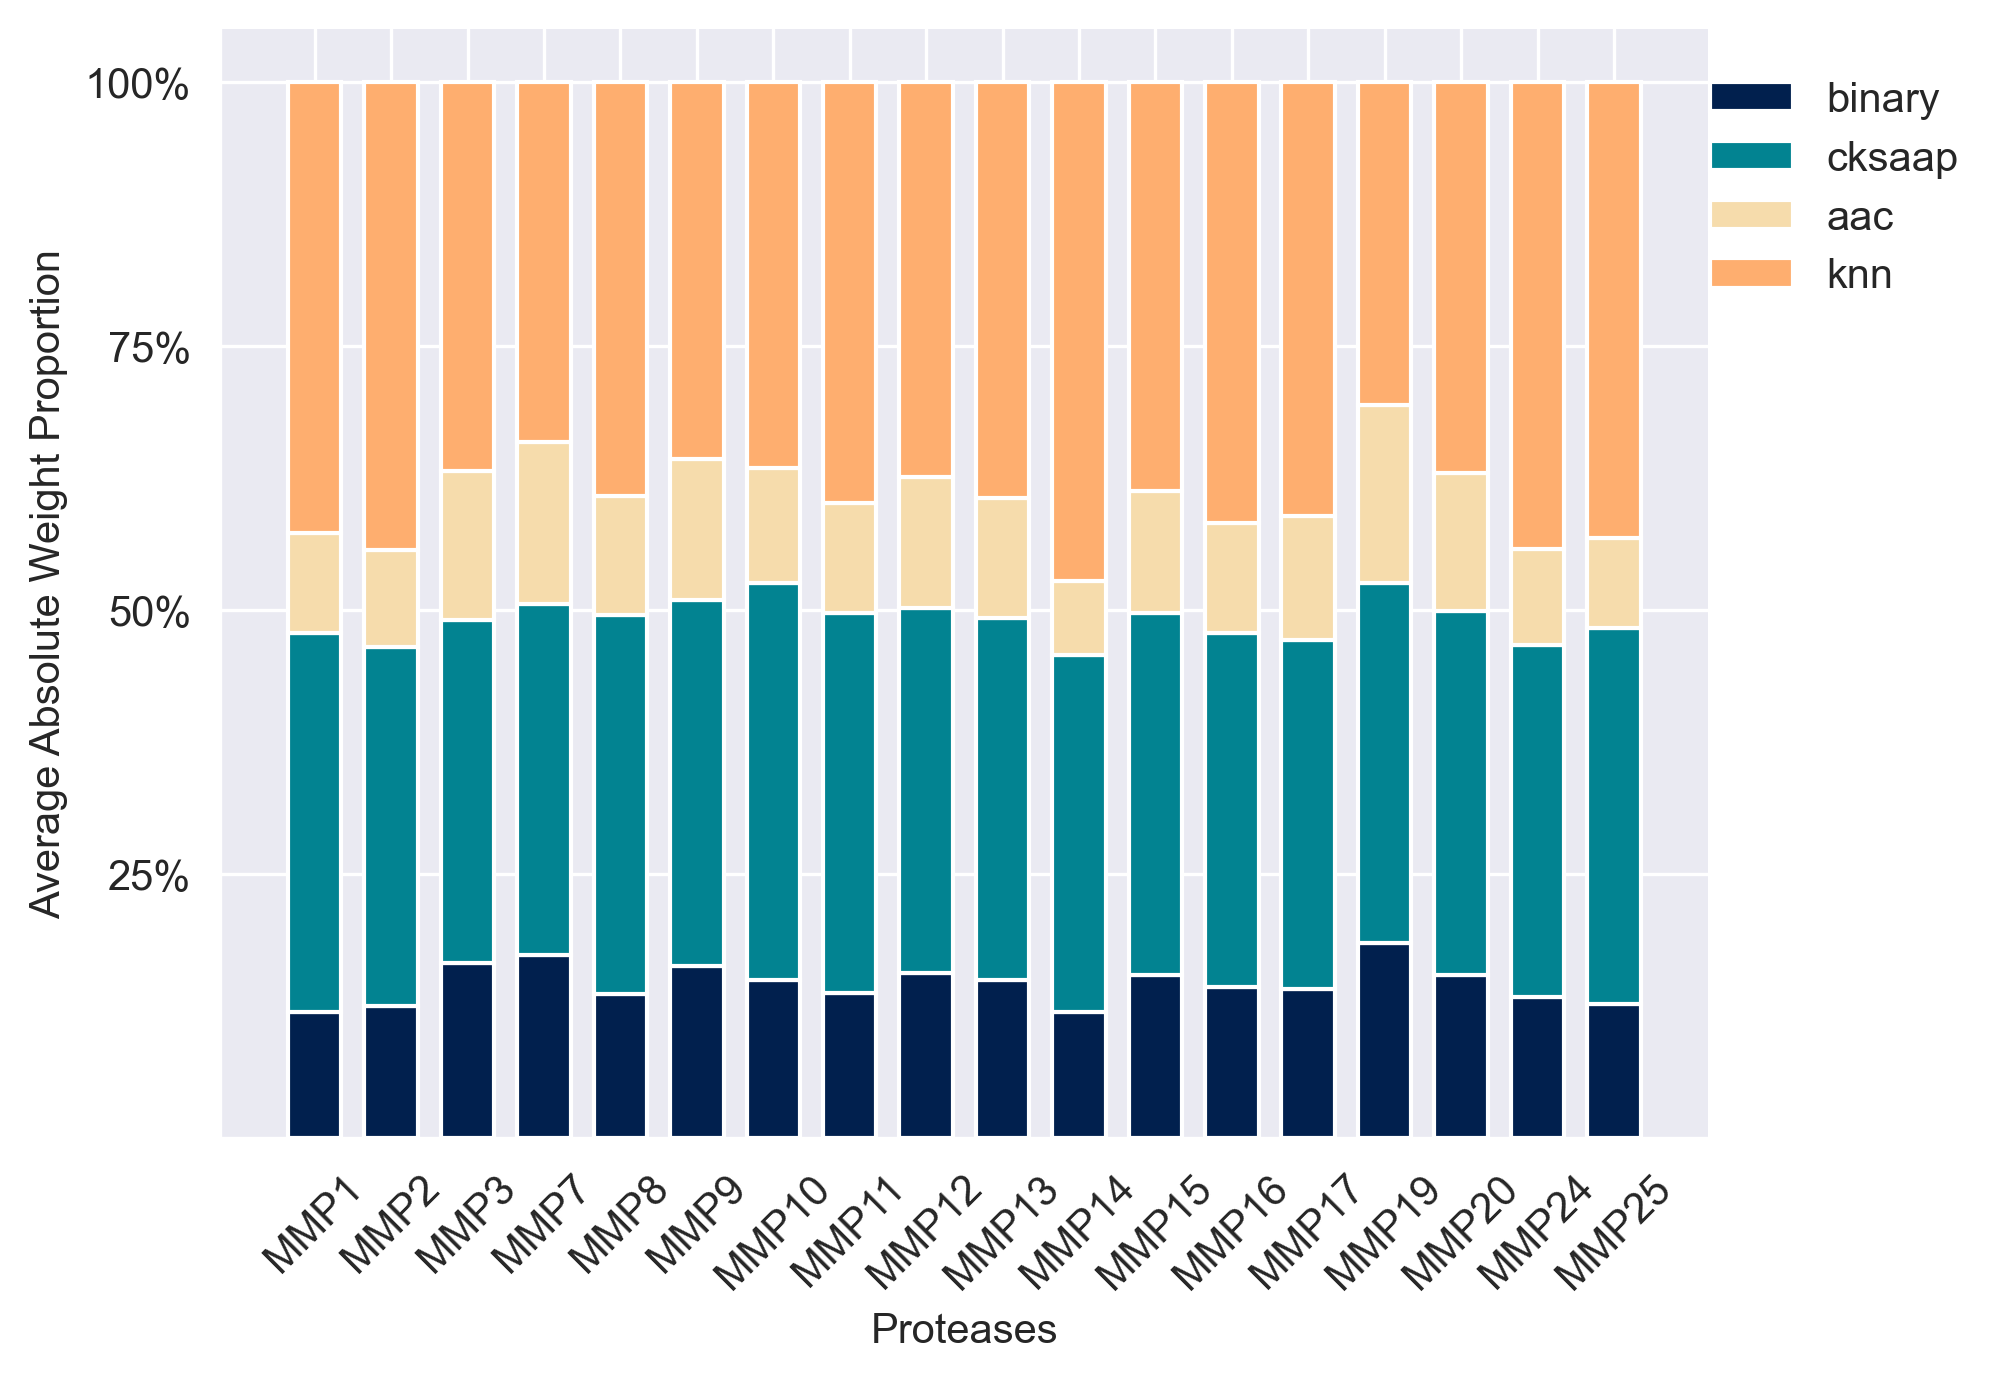

In [7]:
# draw the bar figure.
weight_mean_array = weight_mean_array / weight_mean_array.sum(axis=0)
xticks = pd.read_csv("./Data/processed_peptides10.csv").columns.tolist()[1:]
yticks = ["25%", "50%", "75%", "100%"]

fig, ax = plt.subplots(1, 1, dpi=300)
ax.bar(range(18), weight_mean_array[0], label="binary", color="#01204E", width=0.7)
ax.bar(range(18), weight_mean_array[1], bottom=weight_mean_array[0], label="cksaap", color="#028391", width=0.7)
ax.bar(range(18), weight_mean_array[2], bottom=weight_mean_array[0:2].sum(axis=0), label="aac", color="#F6DCAC", width=0.7)
ax.bar(range(18), weight_mean_array[3], bottom=weight_mean_array[0:3].sum(axis=0), label="knn", color="#FEAE6F", width=0.7)
ax.spines[["top", "right"]].set_visible(False)
ax.set_xticks(range(18), xticks, rotation=45)
ax.set_yticks(np.linspace(0.25, 1, 4), yticks)
ax.set_xlabel("Proteases")
ax.set_ylabel("Average Absolute Weight Proportion")

fig.legend(
    frameon=False, 
    bbox_to_anchor=(1.05, 0.87),  
)

# save the fig
fig.savefig("./Figures/feature_validation.pdf", bbox_inches="tight")